In [2]:
from matplotlib import pyplot as plt
import numpy as np
import json

folders = ['Bayesian','GA', 'GWO', 'PSO', 'SAC', 'TD3']
exp_1 = "20250808_164928_std_wayp_no_initobs_no_wind_large_bounds"
exp_2 = "20250811_162520_std_wayp_yes_initobs_no_wind_small_bounds"
exp_3 = "20250813_094751_std_wayp_yes_initobs_yes_wind_small_bounds"


In [3]:
def _parse_targets(stream):
    """Parse targets from a log that may be NDJSON (one JSON per line)
    or concatenated JSON objects without separators."""
    targets = []
    decoder = json.JSONDecoder()
    buffer = ""

    for line in stream:
        s = line.strip()
        if not s:
            continue
        # Try NDJSON fast-path
        try:
            obj = json.loads(s)
            if "target" in obj:
                targets.append(obj["target"])
            continue
        except json.JSONDecodeError:
            # Fallback: accumulate and raw-decode concatenated JSON
            buffer += line
            try:
                while buffer.strip():
                    obj, idx = decoder.raw_decode(buffer.lstrip())
                    if "target" in obj:
                        targets.append(obj["target"])
                    # advance buffer
                    lead = len(buffer) - len(buffer.lstrip())
                    buffer = buffer[lead + idx:]
            except json.JSONDecodeError:
                # need more data; keep accumulating
                pass

    # Optionally try any trailing buffer as a single JSON
    if buffer.strip():
        try:
            obj = json.loads(buffer)
            if "target" in obj:
                targets.append(obj["target"])
        except json.JSONDecodeError:
            pass

    return targets

In [4]:
all_targets = {}

for folder in folders:
    all_targets[folder] = {}
    for exp_name in [exp_1, exp_2, exp_3]:
        exp_path = f"{folder}/{exp_name}"
        log_path = f"{exp_path}/optimization_log.json"
        try:
            with open(log_path, "r") as f:
                all_targets[folder][exp_name] = _parse_targets(f)
        except FileNotFoundError:
            print(f"Missing file: {log_path}")
            all_targets[folder][exp_name] = []

# Optional: numpy views and a quick summary
all_targets_np = {fd: {en: np.asarray(v, dtype=float)
                       for en, v in inner.items()}
                  for fd, inner in all_targets.items()}

In [5]:
def group(data: np.ndarray, n: int) -> np.ndarray:
    """Group data into chunks of size n getting the increasing absolute minimum for each chunk."""
    new_data = []
    for i in range(0, len(data), n):
        new_data.append(np.min(np.abs(data[0:i+n])))
    return np.array(new_data)    

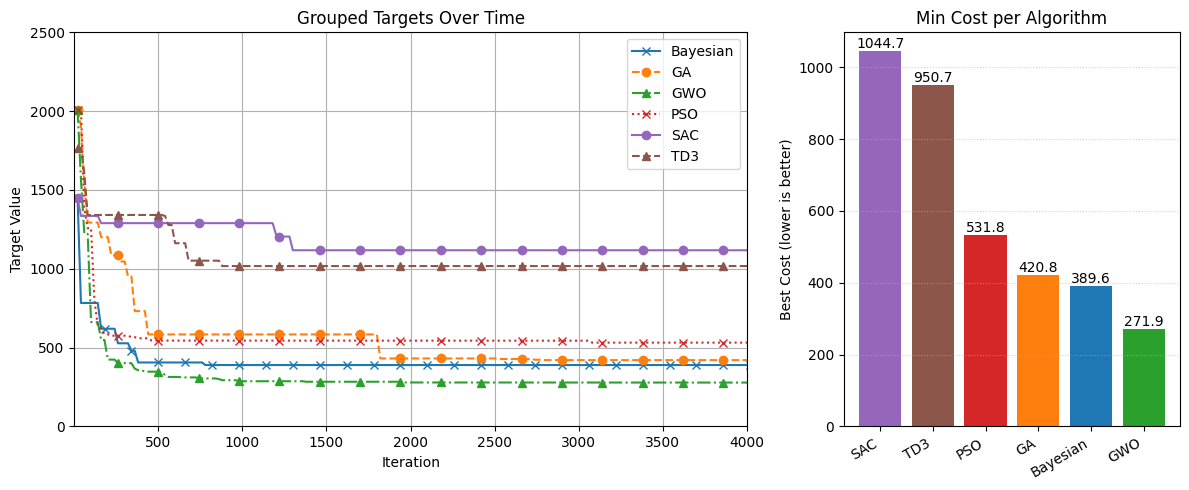

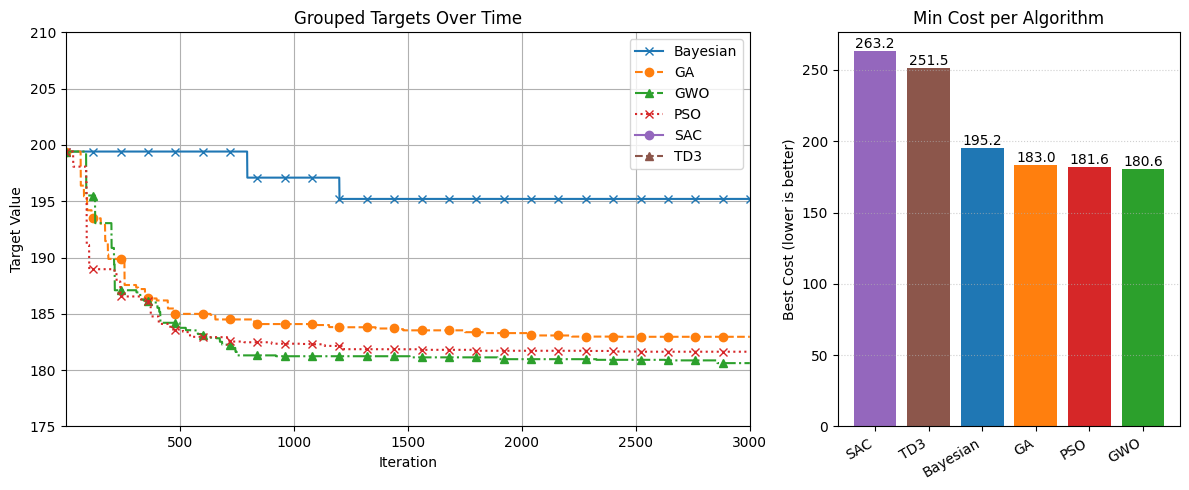

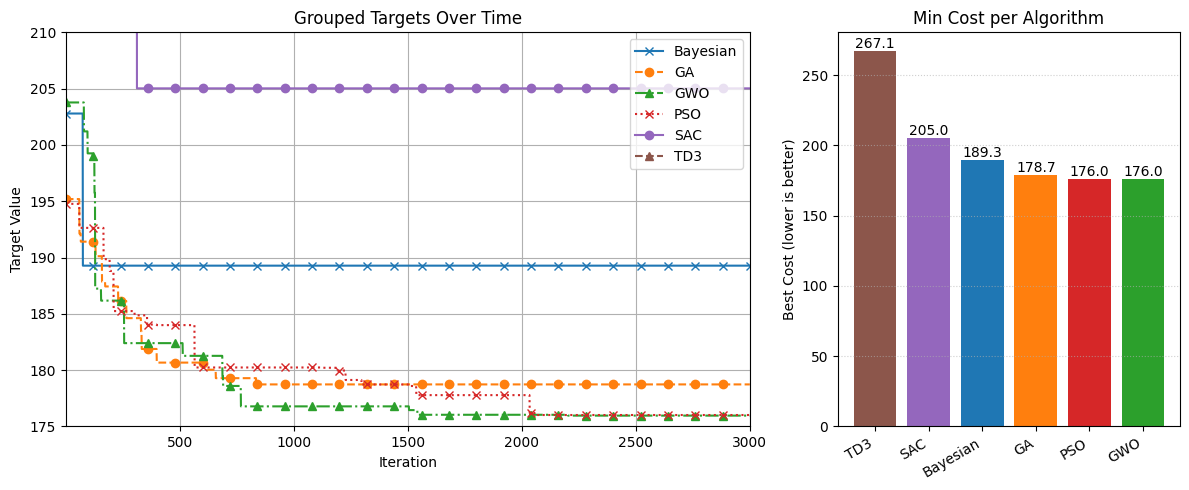

In [26]:
def plot_alg_performance(exp, group_size=20, xlim=None, ylim=None, n_markers=25):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [2, 1]})

    # ---------- Left plot: grouped targets over time ----------
    linestyles = ['-', '--', '-.', ':']
    ss = ['x', 'o', '^']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    color_map = {alg: colors[i % len(colors)] for i, alg in enumerate(folders)}
    global_max_len = 0
    any_series = False

    for algorithm in folders:
        data = all_targets_np.get(algorithm, {}).get(exp, np.array([], dtype=float))
        if data.size == 0:
            continue

        any_series = True
        orig_x_len = len(data)
        global_max_len = max(global_max_len, orig_x_len)

        # Grouped cumulative absolute minimum
        data_red = group(data, group_size)

        # x positions: last index of each group (1-based)
        x_last = np.minimum((np.arange(len(data_red)) + 1) * group_size, orig_x_len)

        axs[0].plot(
            x_last,
            data_red,
            label=f"{algorithm}",
            linestyle=linestyles[folders.index(algorithm) % len(linestyles)],
            marker=ss[folders.index(algorithm) % len(ss)],
            markevery=len(data_red) // n_markers,
            color=color_map[algorithm]
        )

    axs[0].set_title("Grouped Targets Over Time")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Target Value")
    axs[0].grid(True)

    if any_series:
        if xlim is None:
            axs[0].set_xlim(1, global_max_len)
        else:
            axs[0].set_xlim(xlim)
        if ylim is not None:
            axs[0].set_ylim(ylim)
    axs[0].legend(loc='upper right')

    # ---------- Right plot: min cost per algorithm (worst → best) ----------
    min_costs = []
    for algorithm in folders:
        data = all_targets_np.get(algorithm, {}).get(exp, np.array([], dtype=float))
        if data.size == 0:
            continue
        # Use absolute minimum to be consistent with the left plot’s abs minima
        min_val = float(np.min(np.abs(data)))
        min_costs.append((algorithm, min_val))

    if min_costs:
        # Sort by min cost descending: worst (highest) → best (lowest)
        min_costs_sorted = sorted(min_costs, key=lambda kv: kv[1], reverse=True)
        names = [kv[0] for kv in min_costs_sorted]
        values = [kv[1] for kv in min_costs_sorted]

        x = np.arange(len(names))
        bars = axs[1].bar(x, values, color=[color_map[name] for name in names])
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(names, rotation=30, ha="right")
        axs[1].set_ylabel("Best Cost (lower is better)")
        axs[1].set_title("Min Cost per Algorithm")
        axs[1].grid(axis="y", linestyle=":", alpha=0.6)
        # Optional: annotate bars with values
        for rect, val in zip(bars, values):
            axs[1].text(rect.get_x() + rect.get_width()/2.0, rect.get_height(),
                        f"{val:.1f}", ha="center", va="bottom")
    else:
        axs[1].text(0.5, 0.5, "No data to summarize", ha="center", va="center",
                    transform=axs[1].transAxes)
        axs[1].set_axis_off()

    plt.tight_layout()
    plt.show()


plot_alg_performance(exp_1, xlim=(1, 4000), ylim=(0,2500), group_size = 20)
plot_alg_performance(exp_2, xlim=(1, 3000), ylim=(175,210), group_size = 1)
plot_alg_performance(exp_3, xlim=(1, 3000), ylim=(175,210), group_size = 1)
